In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import time

def generate_random_degree_constrained_directed_graph(n, min_degree=1, max_degree=7, weight_range=(1, 10), seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    
    # Step 1: Create a cycle to guarantee each node has at least 1 incoming and 1 outgoing edge.
    for i in range(n):
        G.add_edge(i, (i + 1) % n)
    
    # Step 2: Assign random target degrees for each node.
    target_in = {node: random.randint(min_degree, max_degree) for node in G.nodes()}
    target_out = {node: random.randint(min_degree, max_degree) for node in G.nodes()}
    
    # Step 3: Create a list of candidate edges (excluding existing ones).
    candidate_edges = [(u, v) for u in range(n) for v in range(n) 
                       if u != v and not G.has_edge(u, v)]
    random.shuffle(candidate_edges)
    
    # Add an edge only if it doesn't push the source or destination over its target.
    for u, v in candidate_edges:
        if G.out_degree(u) < target_out[u] and G.in_degree(v) < target_in[v]:
            G.add_edge(u, v)
    
    # Step 4: In case some nodes are still below the minimum (shouldn't happen for min=1 due to the cycle),
    # we do a post-pass to try to fix it.
    for u in range(n):
        # Ensure node u has at least min_degree outgoing edges.
        while G.out_degree(u) < min_degree:
            possible_vs = [v for v in range(n) if v != u and not G.has_edge(u, v) and G.in_degree(v) < target_in[v]]
            if not possible_vs:
                break
            v = random.choice(possible_vs)
            G.add_edge(u, v)
            
        # Ensure node u has at least min_degree incoming edges.
        while G.in_degree(u) < min_degree:
            possible_us = [v for v in range(n) if v != u and not G.has_edge(v, u) and G.out_degree(v) < target_out[v]]
            if not possible_us:
                break
            v = random.choice(possible_us)
            G.add_edge(v, u)
            
    # Step 5: Assign random weights to each edge.
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(weight_range[0], weight_range[1])
    
    return G


def get_weighted_adjacency_matrix(G):
    """
    Converts the weighted graph to an adjacency matrix.
    
    Parameters:
        G (networkx.Graph): The weighted graph.
    
    Returns:
        numpy.ndarray: The weighted adjacency matrix.
    """
    # nx.to_numpy_array will place the weight for each edge,
    # and if there is no edge, it will be 0.
    matrix = nx.to_numpy_array(G, weight='weight', nonedge=0)
    return matrix

def get_weighted_adjacency_list(G):
    """
    Converts the weighted graph to an adjacency list.
    
    Parameters:
        G (networkx.Graph): The weighted graph.
    
    Returns:
        dict: A dictionary where each key is a node and the value is a list 
              of tuples (neighbor, weight) for each edge from that node.
    """
    adj_list = {}
    for node in G.nodes():
        adj_list[node] = []
        for neighbor, data in G[node].items():
            # data is a dict, so get the weight with a default (1) if not set.
            adj_list[node].append((neighbor, data.get('weight', 1)))
    return adj_list


In [2]:
n = 200
min_degree=1
max_degree=3
weight_range = (1, 10)
seed = 42

# Generate the graph.
G = generate_random_degree_constrained_directed_graph(
    n, 
    min_degree, 
    max_degree, 
    weight_range,
    seed
)

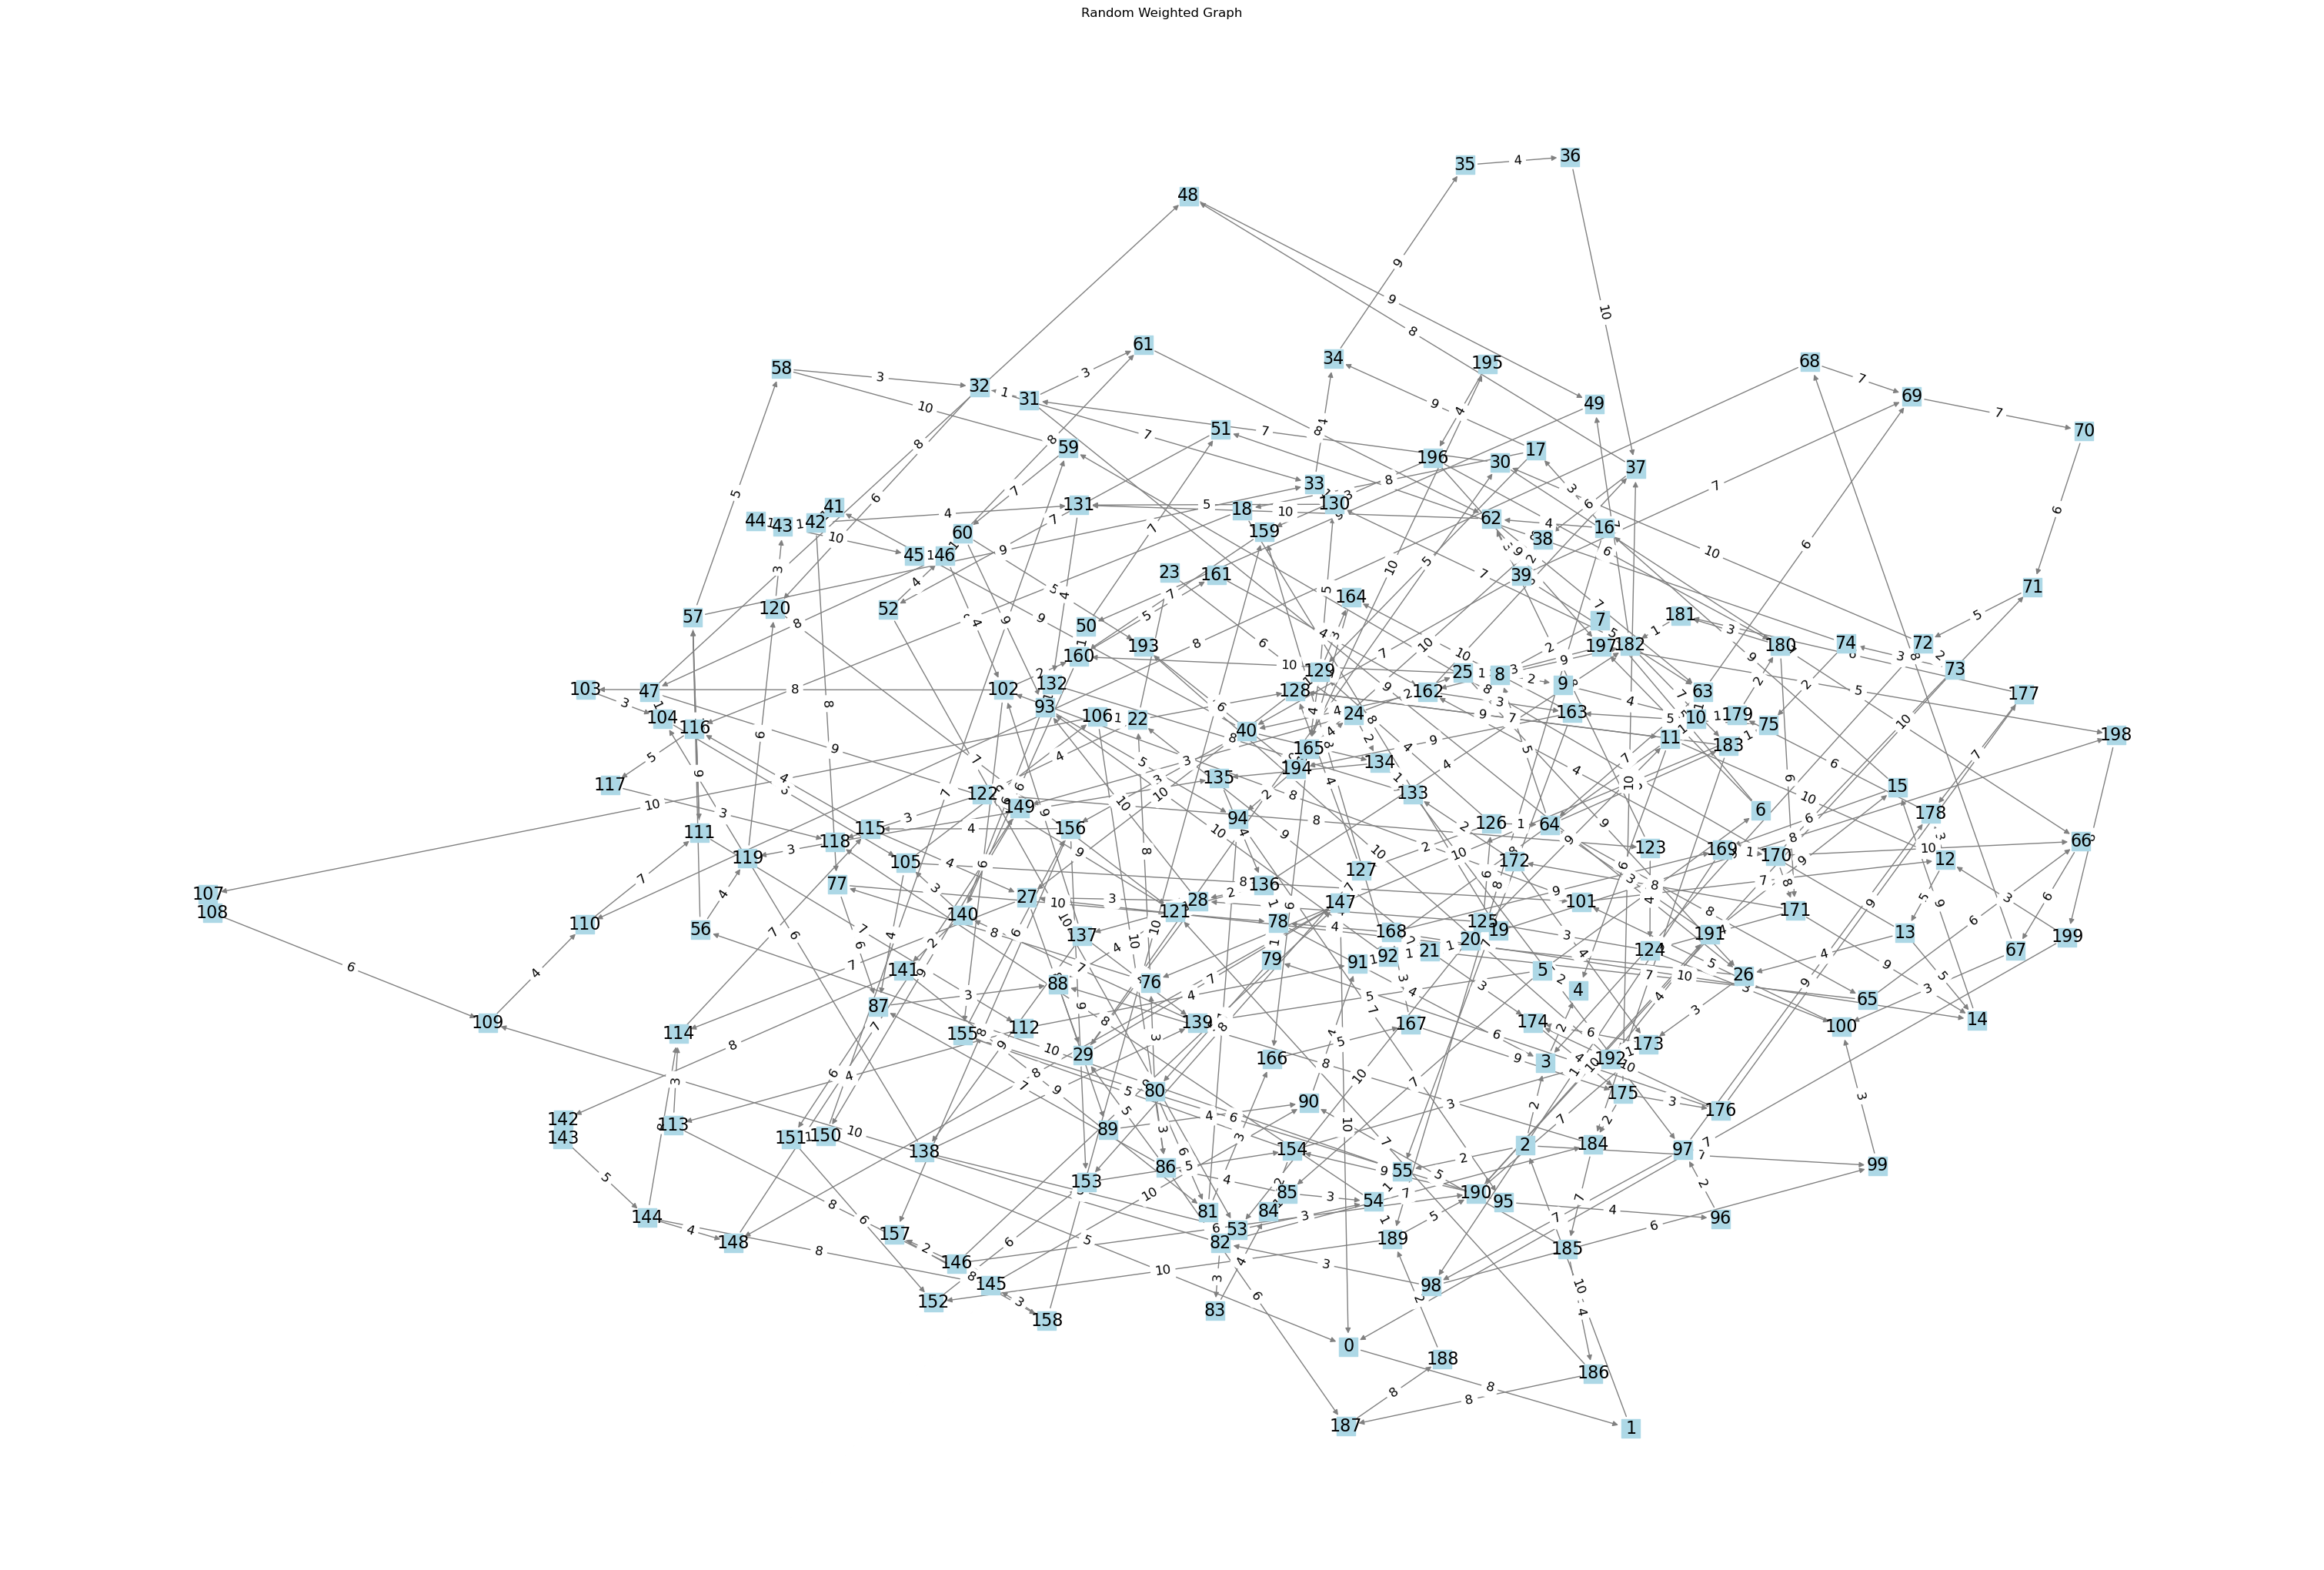

In [3]:
pos = nx.kamada_kawai_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(30, 20))

# Draw just the nodes and edges
nx.draw(
    G, pos,
    with_labels=False,
    node_color='lightblue',
    edge_color='gray',
    node_size=300,
    node_shape='s'
)

# Now draw labels separately, with chosen font sizes
nx.draw_networkx_labels(G, pos, font_size=16)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
plt.title("Random Weighted Graph")
plt.show()

In [4]:
SRC = 107
DEST = 198

### Using adjacency matrix + array for priority queue

In [5]:
class PriorityQueue:
    def __init__(self):
        self.items = []

    def enqueue(self, cost, vertex):
        """
        Insert (cost, vertex) so that the list remains sorted
        by cost in ascending order.
        """
        i = 0
        # Find the position where this (cost, vertex) should be inserted
        while i < len(self.items) and self.items[i][0] <= cost:
            i += 1
        self.items.insert(i, (cost, vertex))

    def dequeue(self):
        """
        Remove and return the (cost, vertex) with the smallest cost,
        which is at the front of the list.
        """
        if self.is_empty():
            raise IndexError("dequeue from empty queue")
        return self.items.pop(0)

    def is_empty(self):
        return len(self.items) == 0

    def __len__(self):
        return len(self.items)



In [6]:
class Model:

    def __init__(self, graph):
        self.G = graph
        n = graph.number_of_nodes()

        self.d = np.full(n, np.inf)
        self.pi = np.full(n, None, dtype=object)
        self.s = np.zeros(n, dtype=bool)

    def run(self, src, dest):
        self.execution_time = None
        start_time = time.perf_counter()
        self.train(src)
        self.print_path(src, dest)
        end_time = time.perf_counter()
        self.execution_time = end_time - start_time
        print(f"Execution Time: {self.execution_time}")

    def print_path(self, src, dest):
        path = self.get_path(src, dest)
        if path is None:
            print(f"No path exists from {src} to {dest}")
        else:
            print(f"Path from {src} to {dest}: {path}")

    def get_path(self, src, dest):
        if self.d[dest] == float('inf'):
            return None
        path = []
        current = dest
        while current != src:
            path.append(current)
            current = self.pi[current]
            if current is None:
                return None
        path.append(src)
        path.reverse()
        return path
    
    def draw_graph_with_path(self, src, dest):
        if self.G is None:
            print("No NetworkX graph provided for visualization.")
            return

        # Get the shortest path as a list of nodes.
        path = self.get_path(src, dest)
        
        plt.figure(figsize=(30, 20))
        nx.draw(
            G, pos,
            with_labels=False,
            node_color='lightblue',
            edge_color='gray',
            node_size=300,
            node_shape='s'
        )

        # Now draw labels separately, with chosen font sizes
        nx.draw_networkx_labels(G, pos, font_size=16)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

        # If a path exists, highlight it.
        if path is not None:
            # Create list of edges in the path.
            path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
            nx.draw_networkx_edges(self.G, pos, edgelist=path_edges,
                                   edge_color='red', width=2)
        else:
            print("No path to highlight.")

        plt.title("Graph with Shortest Path Highlighted")
        plt.show()

In [7]:
class MatrixModel(Model):

    def __init__(self, graph):
        super().__init__(graph)
        self.matrix = get_weighted_adjacency_matrix(graph)
    
    def print_matrix(self):
        # Print the weighted adjacency matrix.
        print("Weighted Adjacency Matrix:")
        print(self.matrix)

    def train(self, src):
        self.d[src] = 0
        pq = PriorityQueue()
        pq.enqueue(self.d[src], src)
        while not pq.is_empty():
            cost, u = pq.dequeue()

            if cost > self.d[u]: # IMPT skip stale u
                continue

            self.s[u] = 1
            
            # For each neighbor v of u, do the relaxation:
            for (v, w) in enumerate(self.matrix[u]):
                if w == 0 or self.s[v] == 1: # no edge or alr visited
                    continue
                new_dist = self.d[u] + w
                if new_dist < self.d[v]:

                    # pq.remove(v) // IMPT see above (skip stale u means no need to remove)

                    # Update distance
                    self.d[v] = new_dist
                    self.pi[v] = u

                    # Enqueue the new (cost, vertex)
                    pq.enqueue(new_dist, v)

In [8]:
model = MatrixModel(G)
model.print_matrix()

Weighted Adjacency Matrix:
[[ 0  8  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  8]
 [ 7  0  0 ...  0  0  0]]


In [9]:
model.run(SRC, DEST)

Path from 107 to 198: [107, 108, 109, 110, 111, 112, 91, 92, 21, 168, 78, 3, 4, 5, 6, 197, 198]
Execution Time: 0.004993027017917484


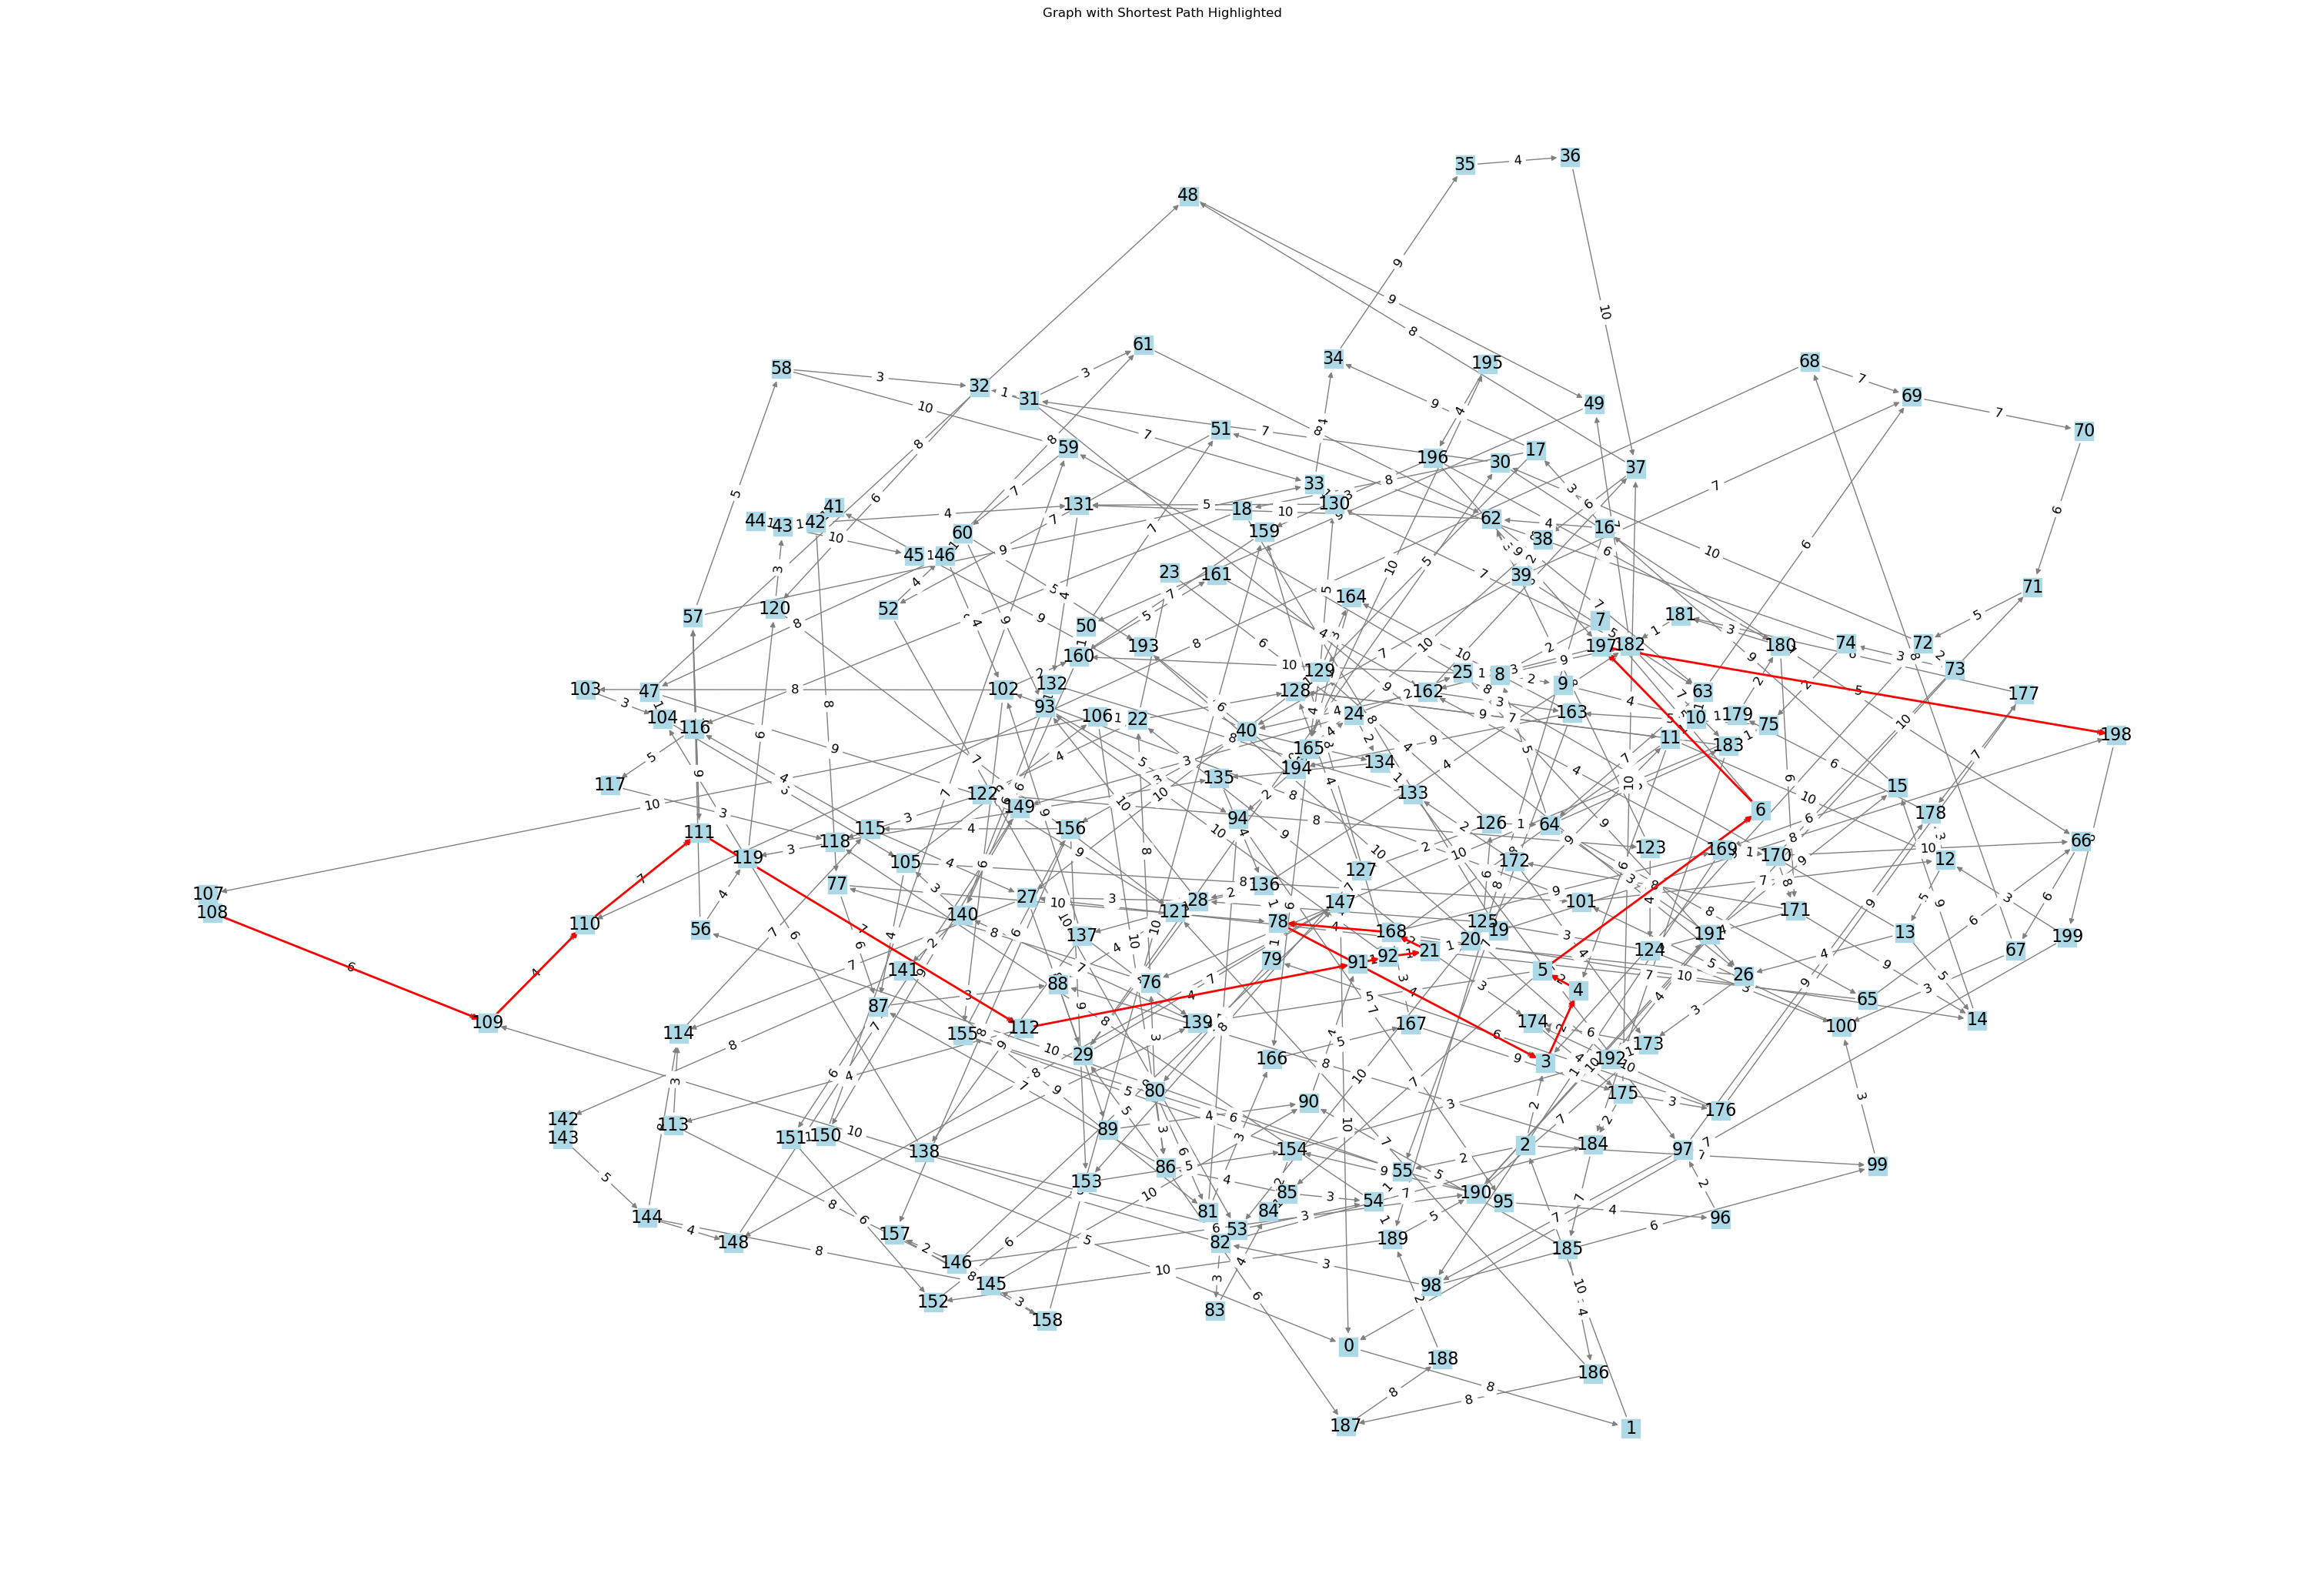

In [10]:
model.draw_graph_with_path(SRC, DEST)

### Using adjacency list + minimizing heap for priority queue

In [11]:
import heapq

class ListModel(Model):

    def __init__(self, graph):
        super().__init__(graph)
        self.adj_list = get_weighted_adjacency_list(graph)
    
    def print_adj_list(self):
        print("\nWeighted Adjacency List:")
        for node, neighbors in self.adj_list.items():
            print(f"{node}: {neighbors}")

    def train(self, src):
        # Initialize the source distance to 0.
        self.d[src] = 0

        # Create a min-heap and push the source node with distance 0.
        min_heap = []
        heapq.heappush(min_heap, (0, src))

        while min_heap:
            # Pop the node with the smallest cost.
            cost, u = heapq.heappop(min_heap)

            # If we already have a better cost for u, skip this one.
            if cost > self.d[u]:
                continue

            # Mark node u as finalized.
            self.s[u] = True

            # For each neighbor v (with edge weight w) of u from the adjacency list.
            for v, w in self.adj_list[u]:
                # Skip if the neighbor is already finalized.
                if self.s[v]:
                    continue

                new_dist = self.d[u] + w

                # If a new shorter path to v is found, update distance and predecessor.
                if new_dist < self.d[v]:
                    self.d[v] = new_dist
                    self.pi[v] = u

                    # Push the new distance for vertex v onto the min-heap.
                    heapq.heappush(min_heap, (new_dist, v))

In [12]:
model = ListModel(G)
model.print_adj_list()


Weighted Adjacency List:
0: [(1, 8)]
1: [(2, 10)]
2: [(3, 2), (55, 2), (99, 7)]
3: [(4, 2)]
4: [(5, 2)]
5: [(6, 5), (85, 7), (139, 5)]
6: [(7, 5), (197, 7)]
7: [(8, 2)]
8: [(9, 2), (160, 10), (182, 9)]
9: [(10, 4)]
10: [(11, 1)]
11: [(12, 10), (91, 8), (4, 6)]
12: [(13, 5), (178, 3)]
13: [(14, 5), (59, 8), (26, 4)]
14: [(15, 9)]
15: [(16, 9), (169, 6)]
16: [(17, 3), (62, 4), (189, 8)]
17: [(18, 8), (129, 5), (34, 9)]
18: [(19, 8), (116, 8)]
19: [(20, 1)]
20: [(21, 1), (198, 8), (11, 9)]
21: [(22, 9), (168, 2), (174, 3)]
22: [(23, 6), (122, 4), (128, 3)]
23: [(24, 6)]
24: [(25, 2), (149, 3), (134, 2)]
25: [(26, 9), (8, 1)]
26: [(27, 9), (173, 3)]
27: [(28, 3), (114, 7), (29, 8)]
28: [(29, 10), (93, 10), (121, 1)]
29: [(30, 10), (147, 7)]
30: [(31, 7), (66, 7)]
31: [(32, 1), (61, 3), (26, 9)]
32: [(33, 7), (120, 6)]
33: [(34, 4)]
34: [(35, 9)]
35: [(36, 4)]
36: [(37, 10)]
37: [(38, 6), (48, 8)]
38: [(39, 2)]
39: [(40, 7), (63, 5), (69, 7)]
40: [(41, 9), (156, 3), (134, 2)]
41: [(42, 1)]

In [13]:
model.run(SRC, DEST)

Path from 107 to 198: [107, 108, 109, 110, 111, 112, 91, 92, 21, 168, 78, 3, 4, 5, 6, 197, 198]
Execution Time: 0.00044979399535804987


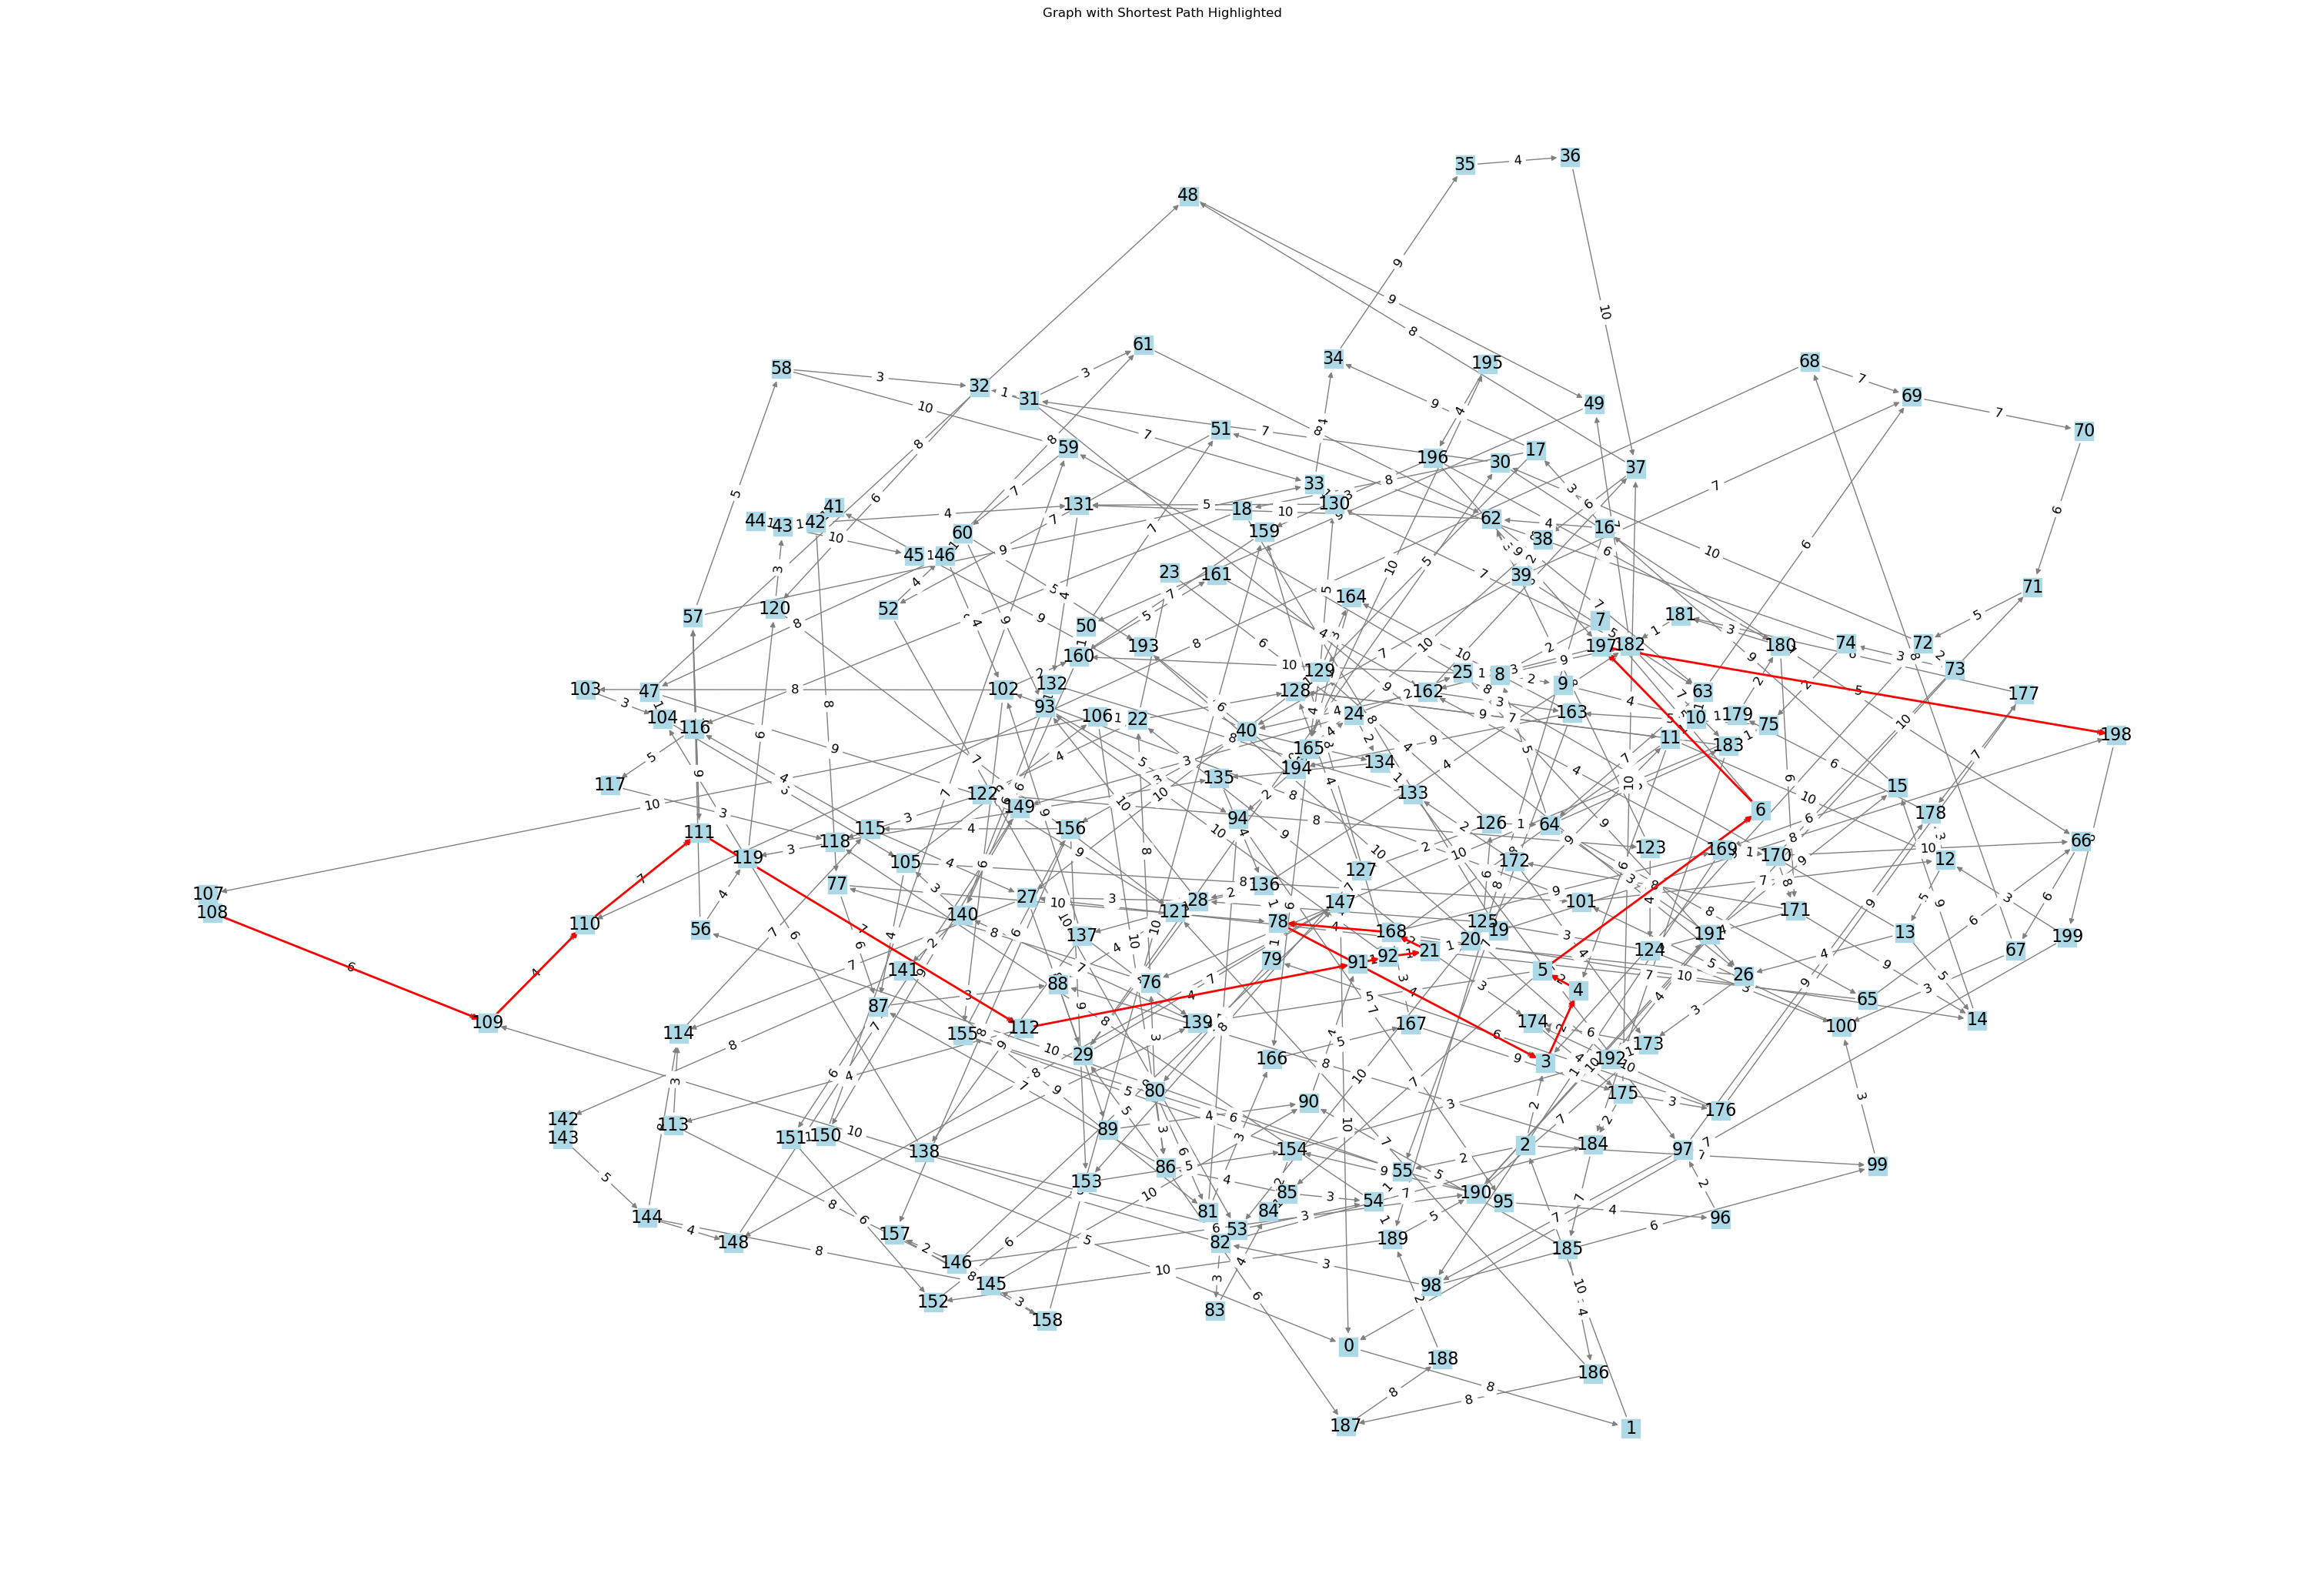

In [14]:
model.draw_graph_with_path(SRC, DEST)

In [15]:
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm

# -------------------------------------------
# 1) Function: Measures the average runtime of Model
# -------------------------------------------
def measure_times(ModelType, graphs, src=0, dest=None):
    """
    Averages runtimes over multiple runs.
    """
    total_time = 0.0

    for graph in graphs:
        model = ModelType(graph)

        # Measure only the algorithm execution time
        start_time = time.perf_counter()
        if dest is not None:
            model.train(src)
            _ = model.get_path(src, dest)
        else:
            model.train(src)
        end_time = time.perf_counter()

        total_time += (end_time - start_time)

    avg_time = total_time / len(graphs)
    return avg_time

# -------------------------------------------
# 2) Process each graph
# -------------------------------------------
def process_graph(n, cfg):
    """
    Runs Dijkstra's algorithm on a graph of size n and returns execution times.
    This function runs **sequentially** (no multiprocessing).
    """

    min_degree = cfg['min_degree']
    max_degree = cfg['max_degree']
    weight_range = cfg['weight_range']
    runs_per_n = cfg['runs_per_n']
    src_node = cfg['src_node']
    seed = cfg['seed']

    # Determine min and max degrees dynamically if callable
    current_min_degree = min_degree(n) if callable(min_degree) else min_degree
    current_max_degree = max_degree(n) if callable(max_degree) else max_degree

    graphs = [generate_random_degree_constrained_directed_graph(
        n, 
        min_degree=current_min_degree, 
        max_degree=current_max_degree, 
        weight_range=weight_range,
        seed=seed + i
    ) for i in range(runs_per_n)]

    matrix_time = measure_times(ModelType=MatrixModel, graphs=graphs, src=src_node)
    list_time = measure_times(ModelType=ListModel, graphs=graphs, src=src_node)

    return (n, matrix_time, list_time)

# -------------------------------------------
# 3) Main test logic: Compare Dijkstra implementations
# -------------------------------------------
def compare_dijkstra_implementations(cfg):
    n_values = cfg['n_values']
    filepath = cfg['filepath']

    with tqdm(total=len(n_values), desc="Processing Graphs") as pbar:
        results = [process_graph(n, cfg) for n in n_values if not pbar.update(1)]

    n_values, matrix_times, list_times = zip(*results)

    df = pd.DataFrame({
        "n_values": n_values,
        "matrix_times": matrix_times,
        "list_times": list_times
    })

    # Save to Parquet
    df.to_parquet(filepath, index=False)


In [ ]:
# n_values = list(range(1, 100))
n_values = list(range(50, 1_000, 5))

sparseCfg = {
    'min_degree': 1,
    'max_degree': 5,
    'weight_range': (1, 10),
    'runs_per_n': 10,  # Number of repetitions per n for averaging
    'src_node': 0,    # src node
    'seed': 42,
    'n_values': n_values,
    'filepath': 'sparse.parquet'
}

denseCfg = {
    'min_degree': lambda n: n / 2,
    'max_degree': lambda n: n,
    'weight_range': (1, 10),
    'runs_per_n': 10,  # Number of repetitions per n for averaging
    'src_node': 0,    # src node
    'seed': 42,
    'n_values': n_values,
    'filepath': 'dense.parquet'
}


In [30]:
compare_dijkstra_implementations(sparseCfg)

Processing Graphs: 100%|██████████| 190/190 [09:21<00:00,  2.96s/it]


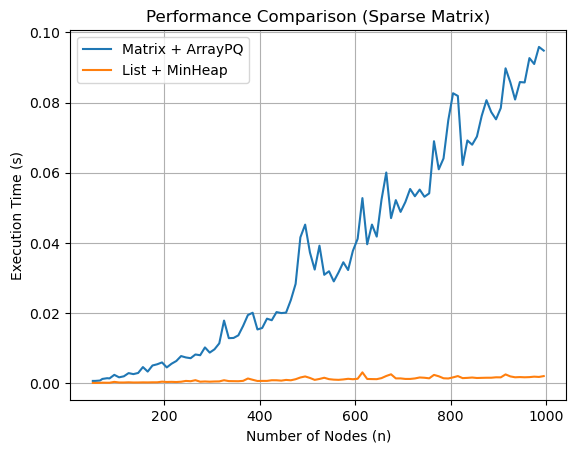

In [31]:
sparse_df = pd.read_parquet(sparseCfg['filepath'])

plt.figure()
plt.plot(sparse_df['n_values'], sparse_df['matrix_times'], label="Matrix + ArrayPQ")
plt.plot(sparse_df['n_values'], sparse_df['list_times'], label="List + MinHeap")
plt.legend()
plt.xlabel("Number of Nodes (n)")
plt.ylabel("Execution Time (s)")
plt.title("Performance Comparison (Sparse Matrix)")
plt.grid()
plt.show()

In [32]:
compare_dijkstra_implementations(denseCfg)

Processing Graphs: 100%|██████████| 190/190 [33:08<00:00, 10.47s/it]


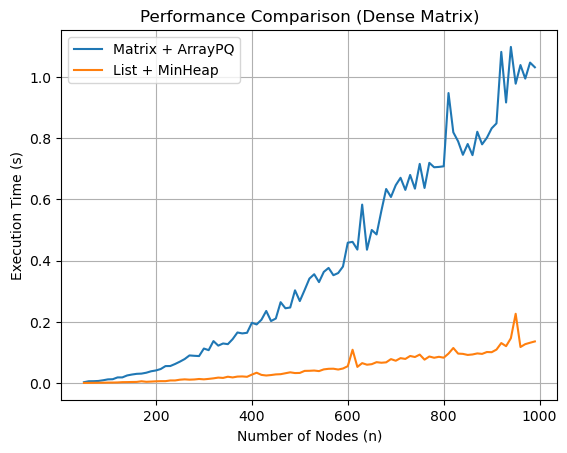

In [33]:
dense_df = pd.read_parquet(denseCfg['filepath'])

plt.figure()
plt.plot(dense_df['n_values'], dense_df['matrix_times'], label="Matrix + ArrayPQ")
plt.plot(dense_df['n_values'], dense_df['list_times'], label="List + MinHeap")
plt.legend()
plt.xlabel("Number of Nodes (n)")
plt.ylabel("Execution Time (s)")
plt.title("Performance Comparison (Dense Matrix)")
plt.grid()
plt.show()